In [ ]:
#importing all the libraries

import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import cv2
import os
import math
import random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Images are stored in dataset folder
data_dir =  "/content/drive/MyDrive/Dataset"
dataset = ImageFolder(data_dir,transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((128,128)),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]))
print(len(dataset))

398


In [ ]:
# Sizes of all the sets
train_size = 350
val_size = 24
test_size= 24
batch_size = 50

In [ ]:
#Splitting and Loading the sets
train_data,val_data,test_data = random_split(dataset,[train_size,val_size,test_size])
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_data, batch_size=24, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_data, batch_size=24, num_workers = 2, pin_memory = True)

In [ ]:
classes = [0,1]  # Flooded - 0 Non-Flooded-1

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()                                     # N = ((n+2p-f)/s)+1

        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),              # Same padding output 128*128*32
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),  # Same padding output 128*128*64
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                           # -> kernel = 2 and stride = 2    # output 64*64*64
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),   # Same padding output 64*64*128
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),  # same padding output 64*64*128
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                              # -> kernel = 2 and stride = 2    # output  32*32*128
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),  # same padding output 32*32*256
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),   # same padding output 32*32*256
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                              # -> kernel = 2 and stride = 2    # output  16*16*256
            
            #Linear Layers
            nn.Flatten(),   
            nn.Linear(65536,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,100),
            nn.ReLU(),
            nn.Linear(100,2)
        )
    
    def forward(self, xb):
        return self.network(xb)

# create a complete CNN
model = Net()
print(model)

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=65536, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=1024, 

In [ ]:
def train(model, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reset the optimizer
        optimizer.zero_grad()
        output = model(data)
        # Get the loss
        loss = loss_criteria(output, target)
        # Keep a running total
        train_loss += loss.item()
        # Backpropagate
        loss.backward()
        optimizer.step()
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))     
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

In [ ]:
def test(model, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss / batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 8 epochs
epochs = 8
for epoch in range(1, epochs + 1):
        train_loss = train(model, train_dl, optimizer, epoch)
        test_loss = test(model, val_dl)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Epoch: 1
	Training batch 1 Loss: 0.660272
	Training batch 2 Loss: 0.472829
	Training batch 3 Loss: 1.149525
	Training batch 4 Loss: 0.391742
	Training batch 5 Loss: 0.538205
	Training batch 6 Loss: 0.564156
	Training batch 7 Loss: 0.576484
Training set: Average loss: 0.621887
Validation set: Average loss: 0.551701, Accuracy: 20/24 (83%)

Epoch: 2
	Training batch 1 Loss: 0.496002
	Training batch 2 Loss: 0.466382
	Training batch 3 Loss: 0.473461
	Training batch 4 Loss: 0.279697
	Training batch 5 Loss: 0.313410
	Training batch 6 Loss: 0.804445
	Training batch 7 Loss: 0.459304
Training set: Average loss: 0.470386
Validation set: Average loss: 0.457053, Accuracy: 20/24 (83%)

Epoch: 3
	Training batch 1 Loss: 0.366129
	Training batch 2 Loss: 0.411397
	Training batch 3 Loss: 0.340770
	Training batch 4 Loss: 0.441846
	Training batch 5 Loss: 0.528940
	Training batch 6 Loss: 0.413101
	Training batch 7 Loss: 0.320739
Training set: Average loss: 0.403275
Validation set: Average loss: 0.452094, Acc

In [ ]:
#Evaluating the model
test(model,test_dl)

Validation set: Average loss: 0.461883, Accuracy: 20/24 (83%)



0.46188250184059143

[0.621887424162456, 0.4703858963080815, 0.40327454039028715, 0.368945700781686, 0.3813309499195644, 0.379400019134794, 0.3728775552340916, 0.37327917984553743]


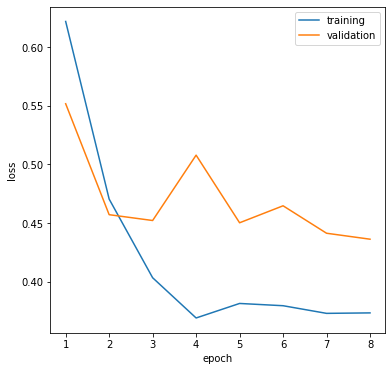

In [ ]:
print(training_loss)
plt.figure(figsize=(6,6))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [ ]:
dataiter = iter(test_dl)
images, labels = dataiter.next()
classes = ('Flooded', 'Non-Flooded')
# print images
im_grid=torchvision.utils.make_grid(images[1:5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  Non-Flooded Non-Flooded Non-Flooded Non-Flooded Non-Flooded
Predicted:    Non-Flooded Non-Flooded Non-Flooded Non-Flooded Non-Flooded


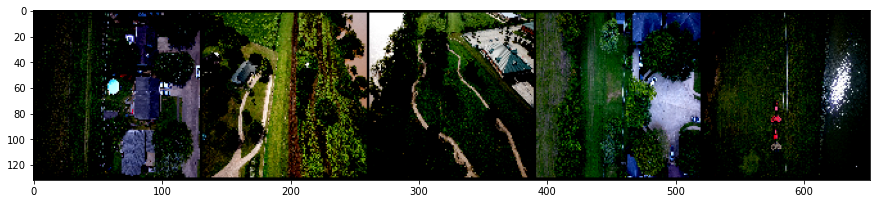

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(im_grid.permute(1,2, 0))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(5)))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%s' % classes[predicted[j]] for j in range(5)))